In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [2]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

# Getting and Cleaning Data

We clean the data of NaN values by simply replacing each NaN value with the mean value of number of visits for each sample.

In [3]:
# Get the time series data.
data_df = pd.read_csv('train_2.csv')

print('data_df.shape = ', data_df.shape)
data_df.head()

data_df.shape =  (145063, 794)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [4]:
# Now fix NaN values in data_df.

means = data_df.drop('Page', axis = 1).mean(axis = 1)
means.fillna(0, inplace = True)

for column in data_df.columns:
    
    data_df[column].fillna(means, inplace = True)

data_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


# Divide Data into Training and Validation

In [5]:
timeSeries = data_df.drop(['Page'], axis = 1).values

In [6]:
# Now get data for training and validation.
futureT = 62

X_all = timeSeries[:, :-futureT]
Y_all = timeSeries[:, -futureT:]

In [7]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
print('X_train.shape = ', X_train.shape, '\tY_train.shape = ', Y_train.shape, 
      '\tX_valid.shape = ', X_valid.shape, '\tY_valid.shape = ', Y_valid.shape)

X_train.shape =  (97192, 731) 	Y_train.shape =  (97192, 62) 	X_valid.shape =  (47871, 731) 	Y_valid.shape =  (47871, 62)


In [8]:
# Now let's set up a data frame to investigate the correlation between the Y_mean and the X_mean.

X_train_m = X_train.mean(axis = 1, keepdims = True)
Y_train_m = Y_train.mean(axis = 1, keepdims = True)

In [10]:
# Let's look at benchmark of average.
epsilon = 1e-6

X_mean = X_train.mean(axis = 1, keepdims = True)
Y_predict = np.full(Y_train.shape, X_mean)
result = smape(epsilon + Y_predict, Y_train)
print('smape = ', result)

smape =  77.5045731276


1 ,6 ,11 ,16 ,21 ,26 ,31 ,36 ,41 ,46 ,51 ,56 ,61 ,66 ,71 ,76 ,81 ,86 ,91 ,96 ,

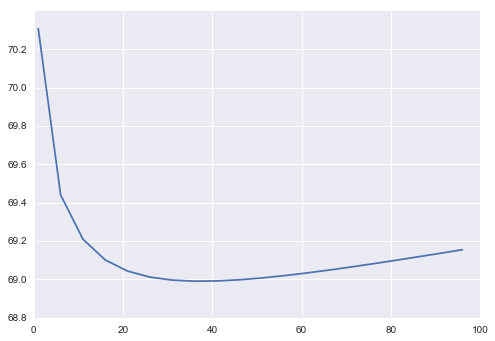

In [11]:
# Let's decide on parameter for log transform.

nSample, nTimes = X_train.shape

epsilon = 1e-6
search = np.arange(1, 100, 5)

results = []
for var in search:
    Z_train = np.log(var + X_train)
    Z_mean = Z_train.mean(axis = 1, keepdims = True)
    Y_predict = np.full((Y_train.shape), -var + np.exp(Z_mean))
    result = smape(epsilon + Y_predict, Y_train)
    results.append(result)
    print(var, ',', end = '')
    
plt.plot(search, results)
plt.show()

In [12]:
param = 30
X_train_lm = np.log(param + X_train).mean(axis = 1, keepdims = True)
Y_train_lm = np.log(param + Y_train).mean(axis = 1, keepdims = True)
means_df = pd.DataFrame(np.concatenate((X_train_lm, Y_train_lm), axis = 1), columns = ['X_train_lm', 'Y_train_lm'])

means_df.head()

,X_train_lm,Y_train_lm
0,4.543886,4.407597
1,4.581753,4.395935
2,3.764482,4.219276
3,7.689277,7.360345
4,4.747078,4.577913


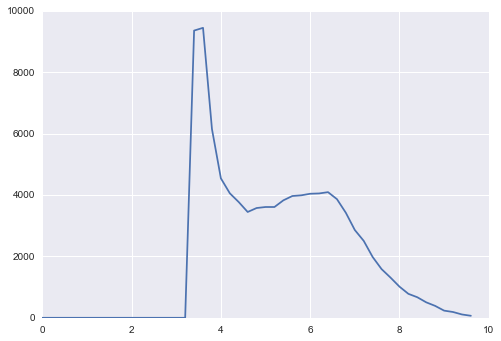

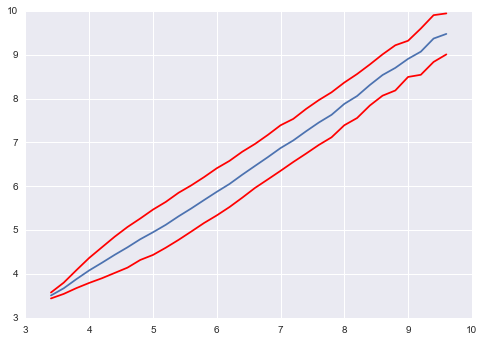

In [13]:
# Let's get a histogram of Y_train_m vs X_train_m.

bins = np.arange(0, 10, 10 / 50)
cut = pd.cut(means_df.X_train_lm, bins = bins)

counts = means_df.groupby(cut).count().Y_train_lm
plt.plot(bins[:-1], counts)
plt.show()

means =  means_df.groupby(cut).mean().Y_train_lm
std = means_df.groupby(cut).std().Y_train_lm
plt.plot(bins[:-1], means)
plt.plot(bins[:-1], means + std, color = 'red')
plt.plot(bins[:-1], means - std, color = 'red')
plt.show()

In [22]:
# Now do a simple linear fit on log transformations.

param = 30
linear = LinearRegression()
X_train_lm = np.log(param + X_train).mean(axis = 1, keepdims = True)
X_valid_lm = np.log(param + X_valid).mean(axis = 1, keepdims = True)
Y_train_l = np.log(param + Y_train)
Y_valid_l = np.log(param + Y_valid)

linear.fit(X_train_lm, Y_train_l)
Y_predict_l = linear.predict(X_valid_lm)
Y_predict = -param + np.exp(Y_predict_l)
result = smape(Y_predict, Y_valid)
print('smape = ', result)

errors = linear.predict(X_train_lm) - Y_train_l
means_df['errors_l1'] = errors.mean(axis = 1, keepdims = True)
means_df.head()

smape =  69.6256903651


,X_train_lm,Y_train_lm,windmean,errors_l1
0,4.543886,4.407597,4.647559,0.051767
1,4.581753,4.395935,4.695509,0.099032
2,3.764482,4.219276,3.829473,-0.492731
3,7.689277,7.360345,7.557451,0.056409
4,4.747078,4.577913,4.728693,0.072499


Now let's consider putting in a window mean of log transforms.

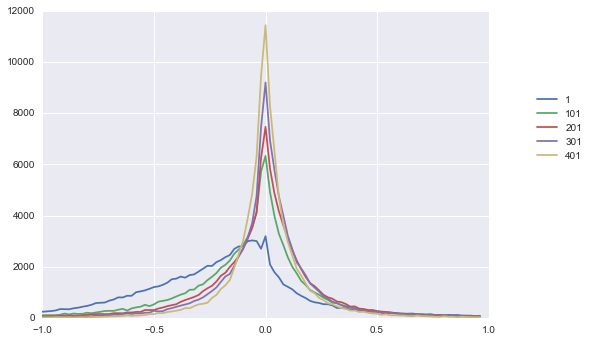

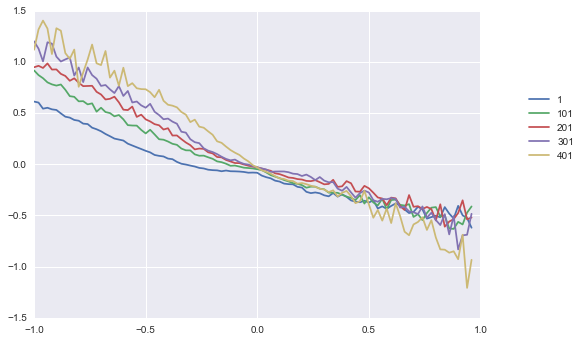

In [25]:
# Try looking at a search on window size for a single window mean.

bins = np.arange(-1, 1, 1/50)

param = 30
search = np.arange(1, 451, 100)

X_train_l = np.log(param + X_train)
means = []
counts = []

for var in search:
    means_df['windmean'] = X_train_l[:, -var:].mean(axis = 1, keepdims = True)
    cut = pd.cut(means_df.windmean - means_df.X_train_lm, bins = bins)

    newcount = means_df.groupby(cut).count().errors_l1
    counts.append(newcount)
    grouped_df = means_df.groupby(cut).mean()
    newmean = grouped_df.errors_l1
    means.append(newmean)
    
counts = np.stack(counts, axis = -1)
plt.plot(bins[:-1], counts)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

means = np.stack(means, axis = -1)
plt.plot(bins[:-1], means)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

It seems we have a dependence on our prediction error depending on whether the window mean log is above or below the entire mean log. So, we can create two new features: the positive part of the difference between the window and the entire means, and the negative part. 

In [53]:
windowSize = 30
param = 30

X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)

features_train = X_train_l.mean(axis = 1)
window = X_train_l[:, -windowSize:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_train_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_train = np.stack([features_train, newfeature1, newfeature2], axis = -1)

features_valid = X_valid_l.mean(axis = 1)
window = X_valid_l[:, -windowSize:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_valid_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
print(newfeature0.shape)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_valid = np.stack([features_valid, newfeature1, newfeature2], axis = -1)

linear = LinearRegression()
linear.fit(features_train, Y_train_l)
Y_predict_l = linear.predict(features_valid)
Y_predict = -param + np.exp(Y_predict_l)
newsmape = smape(Y_predict + epsilon, Y_valid)
print('smape = ', newsmape)

(47871, 2)
smape =  61.4660704609


1 smape =  62.7431147172 , 3 smape =  61.817407769 , 5 smape =  61.5524295947 , 7 smape =  61.0400875756 , 9 smape =  61.0501266526 , 11 smape =  61.1427850463 , 13 smape =  61.151408092 , 15 smape =  61.093972035 , 17 smape =  61.1770420969 , 19 smape =  61.251188426 , 21 smape =  61.2535249462 , 23 smape =  61.3035248161 , 25 smape =  61.4004257667 , 27 smape =  61.4102133692 , 29 smape =  61.4235864385 , 31 smape =  61.5085328059 , 33 smape =  61.5683439013 , 35 smape =  61.5387499581 , 37 smape =  61.5730796374 , 39 smape =  61.645081597 , 41 smape =  61.6865453981 , 43 smape =  61.7105069826 , 45 smape =  61.7997233123 , 47 smape =  61.8711918194 , 49 smape =  61.8721390184 , 51 smape =  61.9362598779 , 53 smape =  62.0018487461 , 55 smape =  62.0254596038 , 57 smape =  62.0317376204 , 59 smape =  62.1007858555 , 61 smape =  62.1405639043 , 63 smape =  62.129200155 , 65 smape =  62.1776853612 , 67 smape =  62.2503603425 , 69 smape =  62.3186943595 , 71 smape =  62.4276811377 , 73 

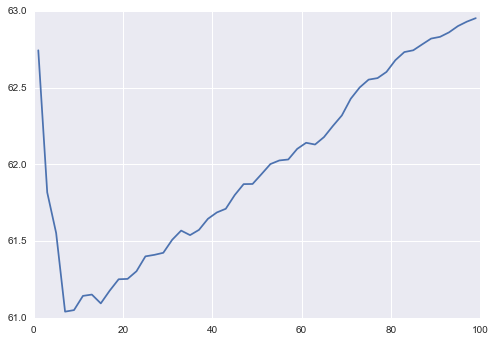

In [52]:
# Now let's try searching over windowSize.

windowSize = 101
param = 30

search = np.arange(1, 100, 2)
X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)

results = []
for var in search:

    features_train = X_train_l.mean(axis = 1)
    window = X_train_l[:, -var:].mean(axis = 1, keepdims = True)
    newfeature0 = window - X_train_lm
    newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
    newfeature1 = np.amax(newfeature0, axis = 1)
    newfeature2 = np.amin(newfeature0, axis = 1)
    features_train = np.stack([features_train, newfeature1, newfeature2], axis = -1)

    features_valid = X_valid_l.mean(axis = 1)
    window = X_valid_l[:, -var:].mean(axis = 1, keepdims = True)
    newfeature0 = window - X_valid_lm
    newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
    newfeature1 = np.amax(newfeature0, axis = 1)
    newfeature2 = np.amin(newfeature0, axis = 1)
    features_valid = np.stack([features_valid, newfeature1, newfeature2], axis = -1)

    linear = LinearRegression()
    linear.fit(features_train, Y_train_l)
    Y_predict_l = linear.predict(features_valid)
    Y_predict = -param + np.exp(Y_predict_l)
    newsmape = smape(Y_predict + epsilon, Y_valid)
    print(var, 'smape = ', newsmape, ', ', end = '')
    results.append(newsmape)
    
plt.plot(search, results)
plt.show()